# motion_segment.py as a Notebook

We'll first load in the model. Then we'll run through one example. Then we'll run through multiple examples.

In [1]:
import os
os.chdir("..")
print(os.getcwd())

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


In [2]:
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
from src.echonet_dataset import zeroone_normalizer
from src.fuse_utils import segment_a_video_with_fusion, compute_ef_using_putative_clips
from src.visualization_utils import make_annotated_gif
import echonet

import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
import numpy as np

import argparse
import sys
import pickle


## Load in our Pre-trained Model

In [3]:
model_name = "Pretrained-R2plus1DMotionSegNet_model.pth"

In [4]:
# load pretrained model
model_save_path = f"save_models/{model_name}"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


### Now we process an example video using our loaded model.

In [3]:
videofile_full_path = "/srv/data/EchoNet-Dynamic/Videos/0X3D42EBE6DAD6A388.avi" # just took a random one
videofile_name_no_extension = "0X3D42EBE6DAD6A388"

In [6]:
capture = cv2.VideoCapture(videofile_full_path)

In [7]:
frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

video = np.zeros((frame_count, frame_height, frame_width, 3), np.uint8)

for count in range(frame_count):
    ret, frame = capture.read()
    if not ret:
        raise ValueError("Failed to load frame #{} of {}.".format(count, filename))

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video[count, :, :] = frame

video = video.transpose((3, 0, 1, 2)).astype(np.float32)


In [8]:
# Pretrained model use the spatial size 112 x 112
# Rescale the video into that spatial size with trilinear interpolation
video = torch.Tensor(video).unsqueeze(0)
video = F.interpolate(video, 
                      size=(video.shape[2], 112, 112), 
                      mode="trilinear", 
                      align_corners=True)

video = video.squeeze().numpy()

video = zeroone_normalizer(video)

class_list = [0, 1]

segmentations = segment_a_video_with_fusion(video, 
                                            model=model, 
                                            interpolate_last=True, 
                                            step=1, 
                                            num_clips=1,
                                            fuse_method="simple", 
                                            class_list=class_list)

predicted_efs, edes_pairs = compute_ef_using_putative_clips(segmentations, 
                                                            test_pat_index=videofile_full_path,
                                                            return_edes=True)

Identified 3 systoles

Ejection fractions measured at each systole are:
Systole #1: ED 40 & ES 61 length=21
EF: 48.64

Systole #2: ED 84 & ES 103 length=19
EF: 49.64

Systole #3: ED 127 & ES 147 length=20
EF: 53.32

The average ejection fraction is 50.53


<Figure size 432x288 with 0 Axes>

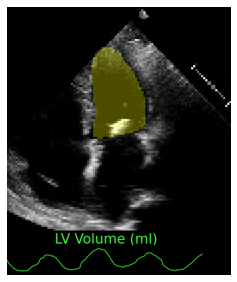

In [9]:
# print out info about systoles, ejection fraction
print("Identified {:d} systoles".format(len(predicted_efs)))
if len(predicted_efs) > 0:
    print("\nEjection fractions measured at each systole are:")
    for i in range(len(predicted_efs)):
        print("Systole #{:d}: ED {:d} & ES {:d} length={:d}".format(i + 1, edes_pairs[i][0], edes_pairs[i][1],
                                                                    edes_pairs[i][1] - edes_pairs[i][0]))
        print("EF: {:.2f}\n".format(predicted_efs[i]))
    print("The average ejection fraction is {:.2f}".format(np.mean(predicted_efs)))


# name of the output file without file extension
filename = videofile_name_no_extension

# output choices are: gif, binary, binary_video, all
content = ["gif"]

# output dir for generated content 
output_dir = "/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking/warren-random/main_seg_save_dir"

# make the content specified 
if "gif" in content or "all" in content:
    make_annotated_gif(segmentations, video, filename= os.path.join(output_dir, filename + "_annotated.gif"))

if "binary" in content or "all" in content:
    for i in range(len(edes_pairs)):
        ed_index = edes_pairs[i][0]
        es_index = edes_pairs[i][1]
        
        with open(os.path.join(output_dir, filename + "_ED_Frame_{:d}_segmentation.pkl".format(ed_index)), "wb") as outfile:
            pickle.dump(segmentations[ed_index], outfile)
        outfile.close()
        
        with open(os.path.join(output_dir, filename + "_ES_Frame_{:d}_segmentation.pkl".format(es_index)), "wb") as outfile:
            pickle.dump(segmentations[es_index], outfile)
        outfile.close()

if "binary_video" in content or "all" in content:
    with open(os.path.join(output_dir, filename + "_whole_video_segmentation.pkl"), "wb") as outfile:
        pickle.dump(segmentations, outfile)
    outfile.close()

## Now let's make it able to do this for a couple of videos at a time that we specify upfront:

I'm just going to smash together the above couple of cells into one function, then make a single video passable through to the function. Then we'll pass through however many videos as we want into the function. We'll make annotated gifs for now.

In [5]:
video_src_folder = "/srv/data/EchoNet-Dynamic/Videos"

In [6]:
vid_names = ["0X1F9B2F6750598383.avi", "0X2EB39D9717E466FB.avi", "0X3D3B33569911F8E9.avi", "0X4BF459CB177B8BE1.avi", "0X5B7DCEC4D8C1E6BB.avi", "0X698851733B8DB622.avi", "0X78B1A9C5DBBE470C.avi", "0XFDFBA5702E94ABF.avi"]

In [7]:
videofile_full_paths = [f"{video_src_folder}/{x}" for x in vid_names]

In [8]:
def run(videofile_full_path, filename, output_dir, content):
    # load in video
    capture = cv2.VideoCapture(videofile_full_path)
    
    # count frames and preprocess video
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video = np.zeros((frame_count, frame_height, frame_width, 3), np.uint8)

    for count in range(frame_count):
        ret, frame = capture.read()
        if not ret:
            raise ValueError("Failed to load frame #{} of {}.".format(count, filename))

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video[count, :, :] = frame

    video = video.transpose((3, 0, 1, 2)).astype(np.float32)

    # Pretrained model use the spatial size 112 x 112
    # Rescale the video into that spatial size with trilinear interpolation
    video = torch.Tensor(video).unsqueeze(0)
    video = F.interpolate(video, 
                          size=(video.shape[2], 112, 112), 
                          mode="trilinear", 
                          align_corners=True)

    video = video.squeeze().numpy()

    video = zeroone_normalizer(video)

    class_list = [0, 1]

    segmentations = segment_a_video_with_fusion(video, 
                                                model=model, 
                                                interpolate_last=True, 
                                                step=1, 
                                                num_clips=1,
                                                fuse_method="simple", 
                                                class_list=class_list)

    predicted_efs, edes_pairs = compute_ef_using_putative_clips(segmentations, 
                                                                test_pat_index=videofile_full_path,
                                                                return_edes=True)
    #####
    # print out info about systoles, ejection fraction
    print("Identified {:d} systoles".format(len(predicted_efs)))
    if len(predicted_efs) > 0:
        print("\nEjection fractions measured at each systole are:")
        for i in range(len(predicted_efs)):
            print("Systole #{:d}: ED {:d} & ES {:d} length={:d}".format(i + 1, edes_pairs[i][0], edes_pairs[i][1],
                                                                        edes_pairs[i][1] - edes_pairs[i][0]))
            print("EF: {:.2f}\n".format(predicted_efs[i]))
        print("The average ejection fraction is {:.2f}".format(np.mean(predicted_efs)))

    # make the content specified 
    if "gif" in content or "all" in content:
        make_annotated_gif(segmentations, video, filename= os.path.join(output_dir, filename + "_annotated.gif"))

    if "binary" in content or "all" in content:
        for i in range(len(edes_pairs)):
            ed_index = edes_pairs[i][0]
            es_index = edes_pairs[i][1]

            with open(os.path.join(output_dir, filename + "_ED_Frame_{:d}_segmentation.pkl".format(ed_index)), "wb") as outfile:
                pickle.dump(segmentations[ed_index], outfile)
            outfile.close()

            with open(os.path.join(output_dir, filename + "_ES_Frame_{:d}_segmentation.pkl".format(es_index)), "wb") as outfile:
                pickle.dump(segmentations[es_index], outfile)
            outfile.close()

    if "binary_video" in content or "all" in content:
        with open(os.path.join(output_dir, filename + "_whole_video_segmentation.pkl"), "wb") as outfile:
            pickle.dump(segmentations, outfile)
        outfile.close()

#############0X1F9B2F6750598383.avi#############
Identified 3 systoles

Ejection fractions measured at each systole are:
Systole #1: ED 64 & ES 85 length=21
EF: 69.45

Systole #2: ED 128 & ES 147 length=19
EF: 55.98

Systole #3: ED 193 & ES 213 length=20
EF: 67.61

The average ejection fraction is 64.35
#############0X2EB39D9717E466FB.avi#############
Identified 2 systoles

Ejection fractions measured at each systole are:
Systole #1: ED 0 & ES 21 length=21
EF: 60.86

Systole #2: ED 124 & ES 142 length=18
EF: 51.44

The average ejection fraction is 56.15
#############0X3D3B33569911F8E9.avi#############
Identified 3 systoles

Ejection fractions measured at each systole are:
Systole #1: ED 0 & ES 18 length=18
EF: 67.03

Systole #2: ED 45 & ES 57 length=12
EF: 57.72

Systole #3: ED 88 & ES 101 length=13
EF: 58.08

The average ejection fraction is 60.94
#############0X4BF459CB177B8BE1.avi#############
Identified 4 systoles

Ejection fractions measured at each systole are:
Systole #1: ED 0 &

<Figure size 432x288 with 0 Axes>

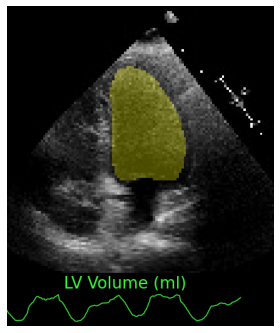

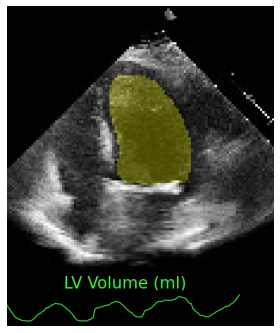

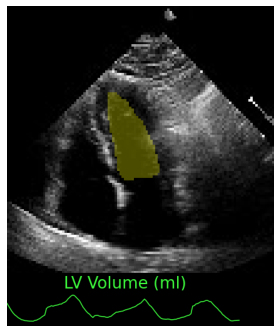

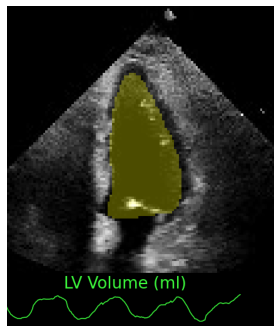

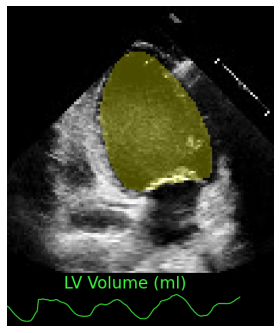

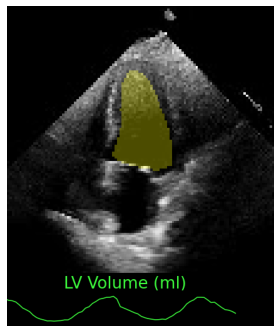

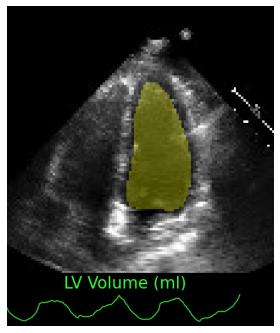

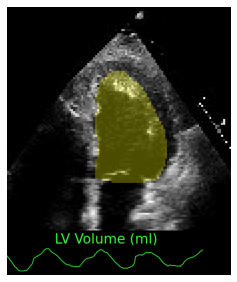

In [9]:
for vidpath, vid in zip(videofile_full_paths, vid_names):
    print(f"############# {vid} #############")
    run(videofile_full_path = vidpath,
        filename = vid[:-4], # trim away file extension
        output_dir = "/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking/warren-random/main_seg_save_dir",
        content = ["gif"])